<h1>Gamma Delta T-cells</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [4]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [5]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [6]:
def visualise_manual_ellipse(sample_go, population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(population)[[x, y]], features_to_transform=[x,y],
                           transform_method='logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

<h2>Manual Gating</h2>

In [7]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [211]:
hc = Gating(exp, 'hc19')

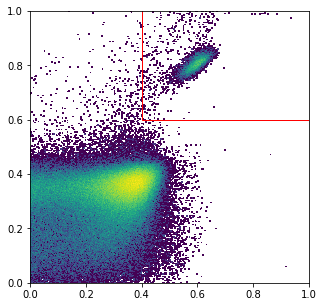

In [200]:
x_min, x_max, y_min, y_max = 0.4, 1.0, 0.6, 1.0
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [201]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_gdt', definition='+')
child_populations.add_population('manual_gdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_gdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

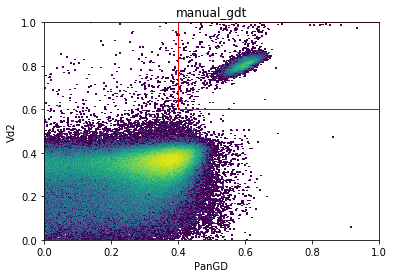

In [202]:
hc.apply('manual_gdt')

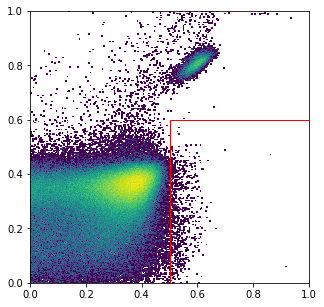

In [203]:
x_min, x_max, y_min, y_max = 0.5, 1.0, 0, 0.6
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [204]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_vd2Neg', definition='+')
child_populations.add_population('manual_vd2NegNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_vd2Neg', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

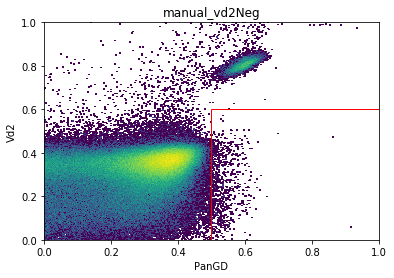

In [205]:
hc.apply('manual_vd2Neg')

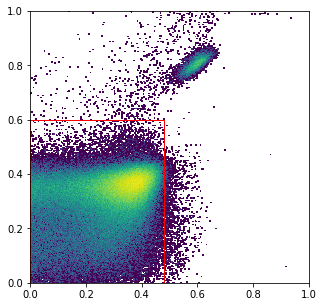

In [206]:
x_min, x_max, y_min, y_max = 0, 0.48, 0, 0.6
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [207]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_nongdt', definition='+')
child_populations.add_population('manual_nongdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_nongdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

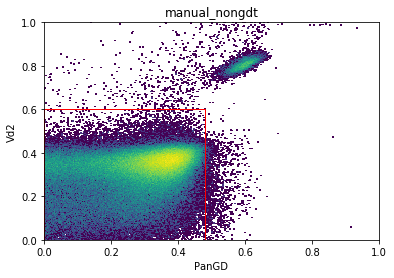

In [208]:
hc.apply('manual_nongdt')

In [209]:
hc.save(overwrite=True)

Saved successfully!


True

<h2>Automated Gates</h2>

In [9]:
hc = Gating(exp, 'hc1')

<h3>Mixture model</h3>

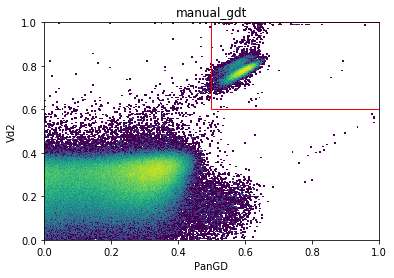

In [9]:
hc.plotting.plot_gate('manual_gdt')

In [10]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_gdt', definition='+')
child_populations.add_population('gmm_gdtNEG', definition='-')

pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

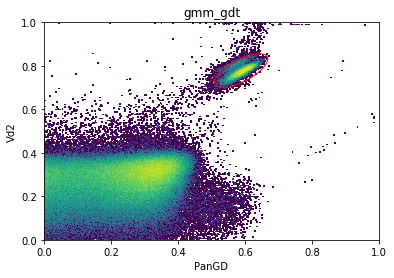

In [11]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=False)

In [12]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_vd2Neg', definition='+')
child_populations.add_population('gmm_vd2NegNEG', definition='-')

pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0, ymax=0.6)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.5, 0.2], conf=0.95, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_vd2Neg', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

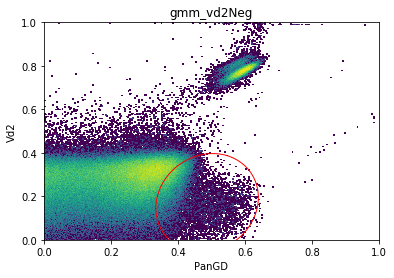

In [13]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_vd2Neg',
                          performance_record=performance, save=False)

In [14]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_nongdt', definition='+')
child_populations.add_population('gmm_nongdtNEG', definition='-')

pre_filter=dict(xmin=0, xmax=0.5, ymin=0, ymax=0.6)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.2, 0.2], conf=0.95, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_nongdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

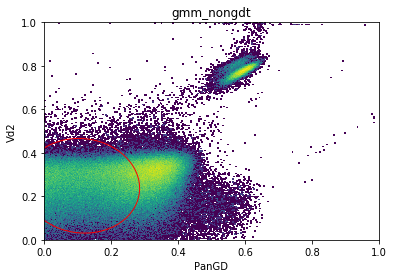

In [15]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_nongdt',
                          performance_record=performance, save=False)

<h3>DBSCAN</h3>

In [16]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                      downsample_method='density', frac=0.2)
hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

Expected 3 populations, identified 4; {0, 1, 2, 3, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.


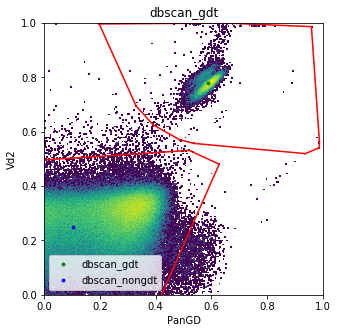

In [17]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=False)

<img src='clever.jpg'>

<h3>HDBSCAN</h3>

In [18]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 0;prioritising hdbscan_nongdt based on weighting.


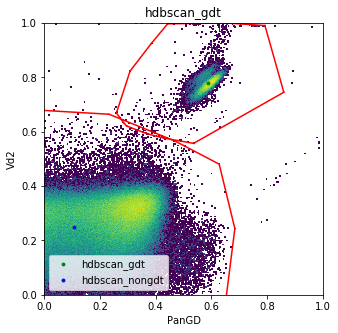

In [19]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                          performance_record=performance, save=False)

<h3>2D Density Threshold</h3>

In [23]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_gdt', definition=['++'])
child_populations.add_population('dens2d_nongdt', definition=['--'])
child_populations.add_population('dens2d_vd2', definition=['-+'])
child_populations.add_population('dens2d_noise', definition=['+-'])
gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

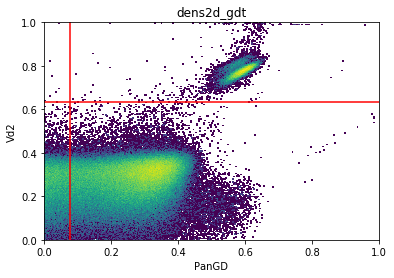

In [24]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=False)

In [8]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [9]:
for x in samples[1:]:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')

    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Gating hc4...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_nongdt based on weighting.
hdbscan...
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 3;prioritising hdbscan_nongdt based on weighting.
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc5...
mixture model...
dbscan...
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 3;prioritising hdbscan_nongdt based on weighting.
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc7...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_gdt', 'dbscan

<h3>Solving DBSCAN cluster assignment error</h3>

In [24]:
hc = Gating(exp, 'hc7')

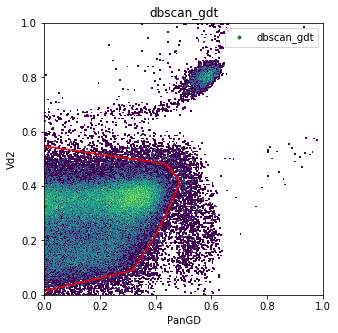

In [25]:
hc.plotting.plot_gate('dbscan_gdt')

In [34]:
from immunova.flow.gating.transforms import apply_transform
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [36]:
from sklearn.neighbors import KDTree
import numpy as np
from functools import partial

In [37]:
def prob_downsample(local_d, target_d, outlier_d):
    if local_d <= outlier_d:
        return 0
    if outlier_d < local_d <= target_d:
        return 1
    if local_d > target_d:
        return target_d / local_d

In [39]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [41]:
sampled = df.sample(frac=0.2, weights=prob)

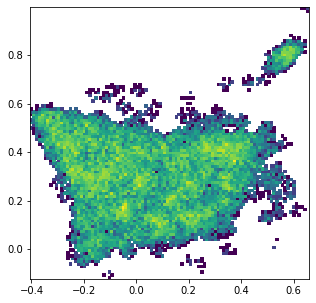

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

In [48]:
hc = Gating(exp, 'hc9')

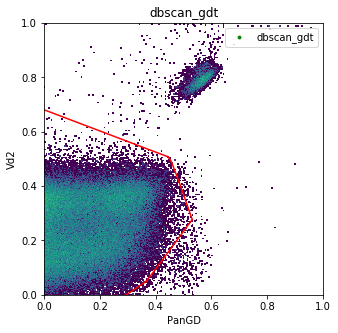

In [49]:
hc.plotting.plot_gate('dbscan_gdt')

In [50]:
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [52]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [53]:
sampled = df.sample(frac=0.2, weights=prob)

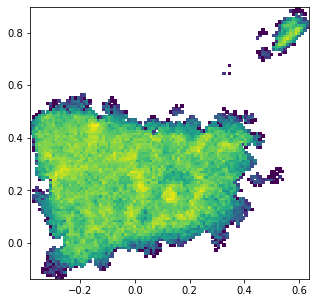

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

In [57]:
hc = Gating(exp, 'hc16')

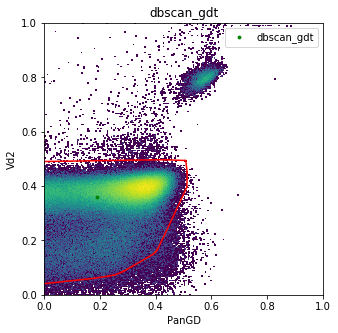

In [58]:
hc.plotting.plot_gate('dbscan_gdt')

In [59]:
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [73]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
if td == 0:
    while td == 0:
        target_dens = target_dens + 0.05
        td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [80]:
sampled = df.sample(frac=0.2, weights=prob)

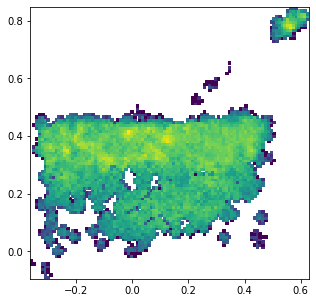

In [81]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

Can conclude that density dependent downsampling still shows good representation of gamma delta t cells. I also know that density dependent downsampling is beneficial because looking at the same plot as above but sampled uniformally gives a far smaller gamma delta population:

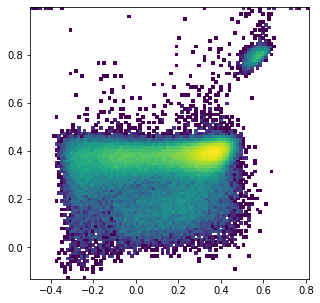

In [82]:
sampled = df.sample(frac=0.2)
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()